### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                              # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.text.all import *                       # Getting all the Libraries.

### **GETTING THE DATA:**
- I will use **Human Numbers** dataset here. It contains the first 10000 numbers written out in English. 

In [6]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.HUMAN_NUMBERS)               # Path to the Dataset. 
path.ls()                                           # Inspecting the Dataset. 

(#2) [Path('/root/.fastai/data/human_numbers/train.txt'),Path('/root/.fastai/data/human_numbers/valid.txt')]

In [7]:
#@ JOINING AND INSPECTING THE DATASET: 
lines = L()                                         # Initializing a List. 
with open(path/"train.txt") as f:                   # Opening the File. 
    lines += L(*f.readlines())                      # Reading the Lines. 
with open(path/"valid.txt") as f:                   # Opening the File. 
    lines += L(*f.readlines())                      # Reading the Lines. 
lines                                               # Inspection. 

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [8]:
#@ PREPARING THE DATASET: 
text = " . ".join([l.strip() for l in lines])       # Preparing the Dataset. 
text[:100]                                          # Inspection. 

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

**Note:**
- I will tokenize the dataset by splitting on spaces. Then I will create a list of unique tokens called vocab for **Numericalization**. Then I will convert the tokens into numbers by looking up in the index of each in the vocab. 

In [9]:
#@ TOKENIZING THE DATASET: 
tokens = text.split(" ")                            # Splitting into Tokens. 
tokens[:10]                                         # Inspecting Tokens. 

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [10]:
#@ GETTING UNIQUE TOKENS: 
vocab = L(*tokens).unique()                         # Getting Unique Tokens. 
vocab                                               # Inspection. 

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [11]:
#@ CONVERTING TOKENS INTO NUMBERS: 
word2idx = {w:i for i,w in enumerate(vocab)}       # Getting Index of Tokens. 
nums = L(word2idx[i] for i in tokens)              # Converting into Numbers. 
nums                                               # Inspection.  

(#63095) [0,1,2,1,3,1,4,1,5,1...]

### **LANGUAGE MODEL FROM SCRATCH:**
- Here I will create a list of every sequence of three words as independent variables and the next word after each sequence as the dependent variable. 

In [12]:
#@ CREATING SEQUENCE OF TOKENS: 
L((tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [13]:
#@ CREATING SEQUENCE OF TENSORS FOR NUMERICALIZED VALUES: 
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3))   # Creating Sequence.
seqs                                                                           # Inspection.  

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [14]:
#@ CREATING DATALOADERS: 
bs = 64                                                 # Initializing Batchsize. 
cut = int(len(seqs) * 0.8)                              # Initialization. 
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], 
                             bs=bs, shuffle=False)      # Initializing Data Loaders. 

**LANGUAGE MODEL:**
- I will create neural network architecture that takes three words as input and returns the predictions of the probability of each possible next word in the vocab. I will use three standard linear layers. The first linear layer will use only the first words embedding as activations. The second layer will use the second words embedding plus the first layers output activations and the third layer will use the third words embedding plus the second layers output activations. The key effect is that every word is interpreted in the information context of any words preceding it. Each of these three layers will use the same weight matrix. 

In [15]:
#@ LANGUAGE MODEL IN PYTORCH: SIMPLE LINEAR MODEL: 
class LMModel1(Module):                                         # Defining Language Model Class. 
    def __init__(self, vocab_sz, n_hidden):                     # Initializing Constructor Function. 
        self.i_h = nn.Embedding(vocab_sz, n_hidden)             # Initializing Embedding Layer. 
        self.h_h = nn.Linear(n_hidden, n_hidden)                # Initializing Linear Layer. 
        self.h_o = nn.Linear(n_hidden, vocab_sz)                # Initializing Linear Layer. 
    
    def forward(self, x):                                       # Forward Propagation Function. 
        h = F.relu(self.h_h(self.i_h(x[:, 0])))                 # Implementation of RELU. 
        h = h + self.i_h(x[:, 1])                               # Second Word Embeddings and Activations. 
        h = F.relu(self.h_h(h))                                 # Implementation of RELU. 
        h = h + self.i_h(x[:, 2])                               # Third Word Embeddings and Activations. 
        h = F.relu(self.h_h(h))                                 # Implementation of RELU. 
        return self.h_o(h)                                      # Implementation of Linear Layer. 

In [16]:
#@ TRAINING THE LANGUAGE MODEL: 
learn = Learner(dls, LMModel1(len(vocab), 64),                  # Initializing Learner with Language Model. 
                loss_func=F.cross_entropy, metrics=accuracy)    # Initializing Cross Entropy Loss Function. 
learn.fit_one_cycle(4, 1e-3)                                    # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,1.824297,1.970941,0.467554,00:01
1,1.386973,1.823242,0.467554,00:01
2,1.417556,1.654498,0.494414,00:01
3,1.376440,1.650849,0.494414,00:01


In [17]:
#@ MODEL EVALUATION: 
n, counts = 0, torch.zeros(len(vocab))                          # Initialization. 
for x, y in dls.valid: 
    n += y.shape[0]
    for i in range_of(vocab):
        counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)                                      # Common Tensor Index. 
idx, vocab[idx.item()], counts[idx].item()/n                    # Inspection. 

(tensor(29), 'thousand', 0.15165200855716662)

### **RECURRENT NEURAL NETWORK:**
- I will simplify the neural networks model or module defined above by replacing the duplicated code that calls the layers with a for loop. The module can work equally to token sequences of different lengths. **Recurrent Neural Network** is a network which is a refactoring of a multilayer neural network using for loop.  

In [18]:
#@ LANGUAGE MODEL IN PYTORCH: RECURRENT NEURAL NETWORK:
class LMModel2(Module):                                         # Defining Language Model Class.
    def __init__(self, vocab_sz, num_hidden):                   # Initializing Constructor Function. 
        self.i_h = nn.Embedding(vocab_sz, num_hidden)           # Initializing Embedding Layer. 
        self.h_h = nn.Linear(num_hidden, num_hidden)            # Initializing Linear Layer. 
        self.h_o = nn.Linear(num_hidden, vocab_sz)              # Initializing Linear Layer. 
    
    def forward(self, x):                                       # Forward Propagation Function.
        h = 0                                                   # Initializing Activations. 
        for i in range(3):
            h = h + self.i_h(x[:, i])                           # Initializing Word Embeddings. 
            h = F.relu(self.h_h(h))                             # Implementation of RELU. 
        return self.h_o(h)                                      # Implementation of Linear Layer. 

**Hidden State:**
- **Hidden State** is defined as the activations that are updated at each step of a recurrent neural network. 

In [19]:
#@ TRAINING THE LANGUAGE MODEL: 
learn = Learner(dls, LMModel2(len(vocab), 64),                  # Initializing Learner with Language Model. 
                loss_func=F.cross_entropy, metrics=accuracy)    # Initializing Cross Entropy Loss Function. 
learn.fit_one_cycle(4, 1e-3)                                    # Training the Model. 

epoch,train_loss,valid_loss,accuracy,time
0,1.816274,1.964143,0.460185,00:01
1,1.423805,1.739964,0.473259,00:01
2,1.430327,1.685171,0.485382,00:01
3,1.388390,1.657033,0.470406,00:01


**IMPROVING RECURRENT NEURAL NETWORK:**
- I will define a stateful **Recurrent Neural Network** as it remembers its activations between different calls to forward which represents its use for different samples in the batch. 

In [20]:
#@ LANGUAGE MODEL IN PYTORCH: RECURRENT NEURAL NETWORK:
class LMModel3(Module):                                         # Defining Language Model Class.
    def __init__(self, vocab_sz, num_hidden):                   # Initializing Constructor Function. 
        self.i_h = nn.Embedding(vocab_sz, num_hidden)           # Initializing Embedding Layer. 
        self.h_h = nn.Linear(num_hidden, num_hidden)            # Initializing Linear Layer. 
        self.h_o = nn.Linear(num_hidden, vocab_sz)              # Initializing Linear Layer. 
        self.h = 0                                              # Initializing Hidden State. 
    
    def forward(self, x):                                       # Forward Propagation Function. 
        for i in range(3):
            self.h = self.h + self.i_h(x[:, i])                 # Initializing Word Embeddings. 
            self.h = F.relu(self.h_h(self.h))                   # Implementation of RELU. 
        out = self.h_o(self.h)                                  # Implementation of Linear Layer. 
        self.h = self.h.detach()                                # Removing all the Gradients History. 
        return out 
    
    def reset(self): self.h = 0                                 # Defining Reset Function. 

**BACKPROPAGATION THROUGH TIME:**
- **Backpropagation through Time** is a process of treating a neural network with effectively one layer per time step as one big model and calculating gradients on it in the usual way. The **BPTT** technique is used to avoid running out of memory and time which detaches the history of computation steps in the hidden state every few time steps. 

In [21]:
#@ ARRANGING THE DATASET: 
m = len(seqs)//bs                                           # Getting Pieces of Sequences. 
m, bs, len(seqs)                                            # Inspection. 

(328, 64, 21031)

In [22]:
#@ FUNCTION FOR REINDEXING: 
def group_chunks(ds, bs):                                   # Defining Function. 
    m = len(ds) // bs                                       # Getting Pieces of Sequences. 
    new_ds = L()                                            # Initialization. 
    for i in range(m):
        new_ds += L(ds[i + m*j] for j in range(bs))     
    return new_ds

In [23]:
#@ CREATING DATA LOADERS: 
cut = int(len(seqs)*0.8)                                    # Initializing Ratio. 
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut],bs),   # Initializing Data Loaders. 
                             group_chunks(seqs[cut:],bs),     
                             bs=bs, drop_last=True,         # Dropping the Last Batch. 
                             shuffle=False)                 # Initializing Order. 

In [24]:
#@ TRAINING THE LANGUAGE MODEL: 
learn = Learner(dls, LMModel3(len(vocab), 64),              # Initializing Learner with Language Model. 
                loss_func=F.cross_entropy,                  # Initilizing Cross Entropy Loss Function. 
                metrics=accuracy, cbs=ModelResetter)        # Initializing Metrics and Callbacks. 
learn.fit_one_cycle(10, 3e-3)                               # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,1.677074,1.827367,0.467548,00:01
1,1.282722,1.870913,0.388942,00:01
2,1.090705,1.651793,0.462500,00:01
3,1.035474,1.529888,0.546394,00:01
4,0.969584,1.652238,0.529567,00:01
5,0.929288,1.645588,0.559615,00:01
6,0.881800,1.608407,0.583654,00:01
7,0.857418,1.630502,0.577644,00:01
8,0.819901,1.661551,0.586298,00:01
9,0.800690,1.652451,0.597596,00:01


In [25]:
#@ CREATING MORE SIGNAL:
sl = 16                                                     # Initializing Sequence Length. 
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1])) 
          for i in range(0, len(nums)-sl-1, sl))            # Initializing Sequence of Tensors. 
cut = int(len(seqs)*0.8)                                    # Initializing Ratio. 
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut],bs),   # Initializing Data Loaders. 
                             group_chunks(seqs[cut:],bs),     
                             bs=bs, drop_last=True,         # Dropping the Last Batch. 
                             shuffle=False)                 # Initializing Order. 

#@ INSPECTING SEQUENCE OF DATASET: 
[L(vocab[o] for o in s) for s in seqs[0]]                   # Inspecting Sequences. 

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [26]:
#@ LANGUAGE MODEL IN PYTORCH: RECURRENT NEURAL NETWORK:
class LMModel4(Module):                                     # Defining Language Model Class.
    def __init__(self, vocab_sz, n_hidden):                 # Initializing Constructor Function. 
        self.i_h = nn.Embedding(vocab_sz, n_hidden)         # Initializing Embedding Layer. 
        self.h_h = nn.Linear(n_hidden, n_hidden)            # Initializing Linear Layer. 
        self.h_o = nn.Linear(n_hidden, vocab_sz)            # Iniitlaizing Linear Layer. 
        self.h = 0                                          # Initializing Hidden State. 
    
    def forward(self, x):                                   # Forward Propagation Function. 
        outs = []                                           # Initialization. 
        for i in range(sl):
            self.h = self.h + self.i_h(x[:, i])             # Initializing Word Embeddings. 
            self.h = F.relu(self.h_h(self.h))               # Implementation of RELU. 
            outs.append(self.h_o(self.h))                   # Implementation of Linear Layer. 
        self.h = self.h.detach()                            # Removing all the Gradients History.
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0                             # Defining Reset Function. 

#@ DEFINING THE LOSS FUNCTION: 
def loss_func(inp, targ):                                   # Defining Loss Function. 
    return F.cross_entropy(inp.view(-1, len(vocab)), 
                           targ.view(-1))                   # Cross Entropy Loss Function with Flatten.

In [27]:
#@ TRAINING THE MODEL: 
learn = Learner(dls, LMModel4(len(vocab), 64),              # Initializing Learner with Language Model. 
                loss_func=loss_func,                        # Initilizing Cross Entropy Loss Function. 
                metrics=accuracy, cbs=ModelResetter)        # Initializing Metrics and Callbacks. 
learn.fit_one_cycle(15, 3e-3)                               # Training the Learner. 

epoch,train_loss,valid_loss,accuracy,time
0,3.285931,3.072032,0.212565,00:00
1,2.330371,1.969522,0.425781,00:00
2,1.742317,1.841378,0.441488,00:00
3,1.470120,1.810856,0.494303,00:00
4,1.298811,1.823128,0.492839,00:00
5,1.176841,1.755437,0.509033,00:00
6,1.070127,1.686965,0.521240,00:00
7,0.972219,1.804640,0.531657,00:00
8,0.890471,1.739735,0.574137,00:00
9,0.824574,1.651549,0.585449,00:00


**MULTI LAYER RECURRENT NEURAL NETWORK:**

In [28]:
#@ LANGUAGE MODEL: MULTI LAYER RECURRENT NEURAL NETWORK:
class LMModel5(Module):                                                 # Defining Language Model Class.
    def __init__(self, vocab_sz, n_hidden, n_layers):                   # Initializing Constructor Function. 
        self.i_h = nn.Embedding(vocab_sz, n_hidden)                     # Initializing Embedding Layer. 
        self.rnn = nn.RNN(n_hidden,n_hidden,n_layers,batch_first=True)  # Initializing RNN.
        self.h_o = nn.Linear(n_hidden, vocab_sz)                        # Initializing Linear Layer. 
        self.h = torch.zeros(n_layers, bs, n_hidden)                    # Initializing Hidden State. 

    def forward(self, x):                                               # Forward Propagation Function. 
        res, h = self.rnn(self.i_h(x), self.h)                          # Implementation of RNN. 
        self.h = h.detach()                                             # Removing all the Gradients History.
        return self.h_o(res)
    
    def reset(self): self.h.zero_()                                     # Defining Reset Function. 

#@ TRAINING THE LANGUAGE MODEL: 
learn = Learner(dls, LMModel5(len(vocab), 64, 2),                       # Initializing Learner with Multilayer RNN. 
                loss_func=CrossEntropyLossFlat(),                       # Initializing Cross Entropy Loss Function. 
                metrics=accuracy, cbs=ModelResetter)                    # Initializing Metrics and Callbacks. 
learn.fit_one_cycle(15, 3e-3)                                           # Training the Learner.  

epoch,train_loss,valid_loss,accuracy,time
0,3.041790,2.548715,0.455811,00:00
1,2.128514,1.708763,0.471029,00:00
2,1.699163,1.866050,0.340576,00:00
3,1.499681,1.738478,0.471517,00:00
4,1.339090,1.729538,0.494792,00:00
5,1.206317,1.835860,0.502848,00:00
6,1.088240,1.845545,0.520101,00:00
7,0.982787,1.856240,0.522624,00:00
8,0.890790,1.940332,0.525716,00:00
9,0.809585,2.028807,0.529785,00:00


**Note:**
- The single layer **Recurrent Neural Network** performed better than **Multilayer Recurrent Neural Network** because a deeper model leads to exploding and vanishing activations. 

### **LONG SHORT TERM MEMORY:**

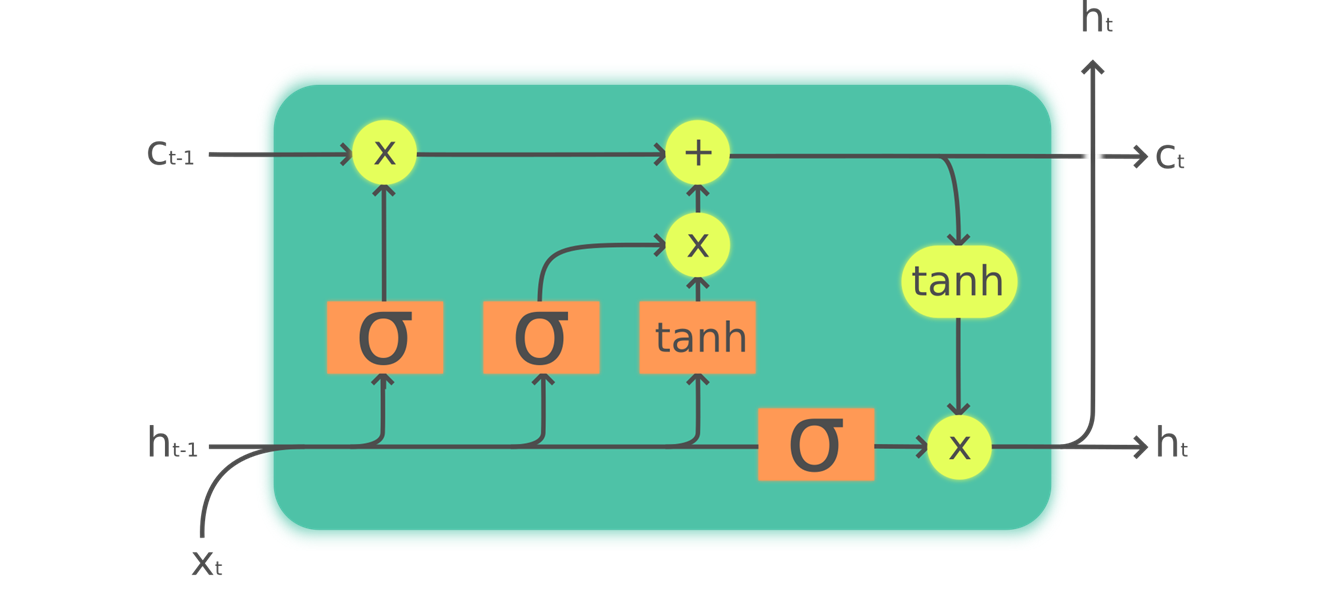

- The green circles are elementwise operations and the four orange boxes represent four neural network layers which are also called gates with the activations. The first gate from left is called the **forget gate**. The second gate is called the **input gate** and the third gate is sometimes called the **cell gate**. The last gate is the **output gate**. **Tanh** is just a **Sigmoid** function rescaled to the range of -1 and 1. 

In [29]:
#@ BUILDING AN LSTM FROM SCRATCH: DETAILED IMPLEMENTATION:
class LSTMCell(Module):                                     # Defining LSTM Class. 
    def __init__(self, ni, nh):                             # Initializing Constructor Function. 
        self.forget_gate = nn.Linear(ni + nh, nh)           # Initializing Forget Gate.
        self.input_gate = nn.Linear(ni + nh, nh)            # Initializing Input Gate. 
        self.cell_gate = nn.Linear(ni + nh, nh)             # Initializing Cell Gate. 
        self.output_gate = nn.Linear(ni + nh, nh)           # Initializing Output Gate. 
    
    def forward(self, input, state):                        # Forward Propagation Function. 
        h, c = state                                        # Initializing Previous Hidden State and Cell State. 
        h = torch.cat([h, input], dim=1)                    # Initializing Concatenation. 
        forget = torch.sigmoid(self.forget_gate(h))         # Implementation of Forget Gate. 
        c = c * forget                                      # Initializing Elementwise Multiplication. 
        inp = torch.sigmoid(self.input_gate(h))             # Implementation of Input Gate. 
        cell = torch.tanh(self.cell_state(h))               # Implementation of Cell Gate. 
        c = c + inp * cell                                  # Initializing Elementwise Multiplication. 
        out = torch.sigmoid(self.output_gate(h))            # Implementation of Output Gate. 
        h = out * torch.tanh(c)                             # Getting Hidden State. 
        return h, (h, c)

In [30]:
#@ BUILDING AN LSTM FROM SCRATCH: OPTIMIZED IMPLEMENTATION:
class LSTMCell(Module):                                     # Defining LSTM Class.
    def __init__(self, ni, nh):                             # Initializing Constructor Function. 
        self.ih = nn.Linear(ni, 4*nh)                       # Initializing Linear Layer. 
        self.hh = nn.Linear(nh, 4*nh)                       # Initializing Linear Layer. 
    
    def forward(self, input, state):                        # Forward Propagation Function.
        h, c = state                                        # Initializing Previous Hidden State and Cell State.
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)   # Initializing Gates and Splitting Tensors. 
        ingate, forgetgate, outgate = map(torch.sigmoid, 
                                          gates[:3])        # Initializing Gates. 
        cellgate = gates[3].tanh()                          # Implementation of Cell Gate. 
        c = (forgetgate*c) + (ingate*cellgate)              # Initializing Cell State. 
        h = outgate * c.tanh()                              # Initializing Hidden State. 
        return h, (h, c)